Request

In [3]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2024-12-01",
	"end_date": "2025-01-01",
	"hourly": ["temperature_2m", "precipitation", "snowfall", "rain", "wind_speed_10m"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["snowfall"] = hourly_snowfall
hourly_data["rain"] = hourly_rain
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_weather = pd.DataFrame(data = hourly_data)
print(hourly_weather)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s
                         date  temperature_2m  precipitation  snowfall  rain  \
0   2024-12-01 04:00:00+00:00         -2.0775            0.0       0.0   0.0   
1   2024-12-01 05:00:00+00:00         -2.4775            0.0       0.0   0.0   
2   2024-12-01 06:00:00+00:00         -2.8275            0.0       0.0   0.0   
3   2024-12-01 07:00:00+00:00         -3.1775            0.0       0.0   0.0   
4   2024-12-01 08:00:00+00:00         -3.5775            0.0       0.0   0.0   
..                        ...             ...            ...       ...   ...   
763 2025-01-01 23:00:00+00:00          4.6725            0.0       0.0   0.0   
764 2025-01-02 00:00:00+00:00          4.3225            0.0       0.0   0.0   
765 2025-01-02 01:00:00+00:00          4.8225            0.0       0.0   0.0   
766 2025-01-02 02:00:00+00:00          4.3225     

In [4]:
hourly_weather.dtypes

date              datetime64[ns, UTC]
temperature_2m                float32
precipitation                 float32
snowfall                      float32
rain                          float32
wind_speed_10m                float32
dtype: object

In [5]:
# Convert to datetime[us] (microsecond precision)& Remove Timezone info for standardisation
hourly_weather['date'] = hourly_weather['date'].dt.tz_convert('UTC').dt.tz_localize(None)

hourly_weather.head(10)

,date,temperature_2m,precipitation,snowfall,rain,wind_speed_10m
0,2024-12-01 04:00:00,-2.0775,0.0,0.0,0.0,10.449306
1,2024-12-01 05:00:00,-2.4775,0.0,0.0,0.0,8.227004
2,2024-12-01 06:00:00,-2.8275,0.0,0.0,0.0,6.681856
3,2024-12-01 07:00:00,-3.1775,0.0,0.0,0.0,7.386582
4,2024-12-01 08:00:00,-3.5775,0.0,0.0,0.0,7.412853
5,2024-12-01 09:00:00,-3.8775,0.0,0.0,0.0,5.942727
6,2024-12-01 10:00:00,-3.9275,0.0,0.0,0.0,5.991594
7,2024-12-01 11:00:00,-3.9275,0.0,0.0,0.0,6.341009
8,2024-12-01 12:00:00,-3.9275,0.0,0.0,0.0,6.050785
9,2024-12-01 13:00:00,-3.3775,0.0,0.0,0.0,8.297589


In [17]:
hourly_weather.to_excel(excel_writer="/Users/ikmalbasirun/Documents/GitHub/NYC_Transportation_Demand/data/processed/hourly_weather_nyc.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

<Axes: xlabel='date', ylabel='temperature_2m'>

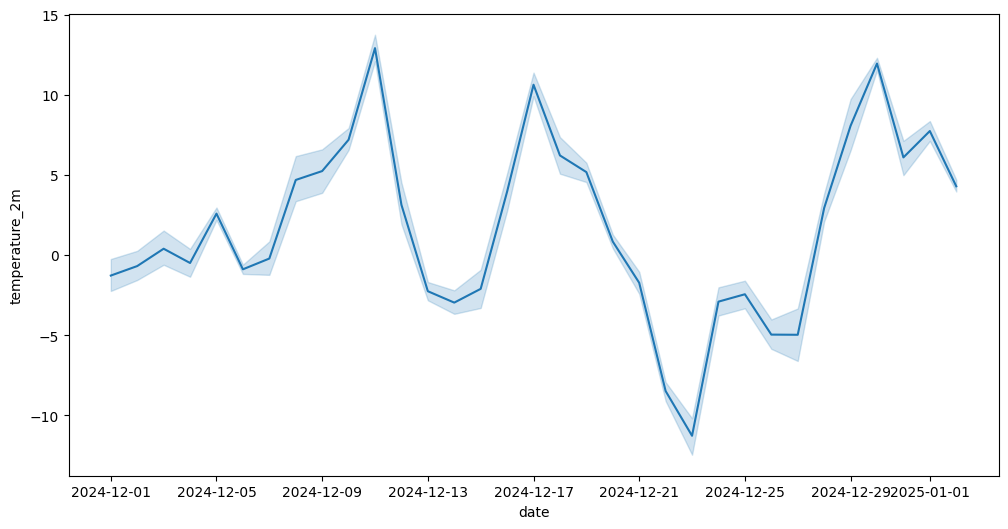

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_weather, x=hourly_weather['date'].dt.date, y= 'temperature_2m')